In [2]:
import pandas as pd
import numpy as np
import cv2    
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
import tensorflow as tf
print(tf.__version__)

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import np_utils
#from keras.optimizers import SGD

from IPython.core.display import display, HTML
from PIL import Image
from io import BytesIO
import base64

plt.style.use('ggplot')

%matplotlib inline

2.6.4


## exploratory analysis ##


In [3]:
# set variables 
main_folder = '../input/celeba-dataset/'
images_folder = main_folder + 'img_align_celeba/img_align_celeba/'

EXAMPLE_PIC = images_folder + '000506.jpg'

TRAINING_SAMPLES = 10000
VALIDATION_SAMPLES = 2000
TEST_SAMPLES = 2000
IMG_WIDTH = 178
IMG_HEIGHT = 218
BATCH_SIZE = 16
NUM_EPOCHS = 20

In [4]:
df_attr = pd.read_csv(main_folder + 'list_attr_celeba.csv')
df_attr.set_index('image_id', inplace=True)
df_attr.replace(to_replace=-1, value=0, inplace=True) #replace -1 by 0
df_attr.shape

(202599, 40)

In [5]:
# List of available attributes
for i, j in enumerate(df_attr.columns):
    print(i, j)

0 5_o_Clock_Shadow
1 Arched_Eyebrows
2 Attractive
3 Bags_Under_Eyes
4 Bald
5 Bangs
6 Big_Lips
7 Big_Nose
8 Black_Hair
9 Blond_Hair
10 Blurry
11 Brown_Hair
12 Bushy_Eyebrows
13 Chubby
14 Double_Chin
15 Eyeglasses
16 Goatee
17 Gray_Hair
18 Heavy_Makeup
19 High_Cheekbones
20 Male
21 Mouth_Slightly_Open
22 Mustache
23 Narrow_Eyes
24 No_Beard
25 Oval_Face
26 Pale_Skin
27 Pointy_Nose
28 Receding_Hairline
29 Rosy_Cheeks
30 Sideburns
31 Smiling
32 Straight_Hair
33 Wavy_Hair
34 Wearing_Earrings
35 Wearing_Hat
36 Wearing_Lipstick
37 Wearing_Necklace
38 Wearing_Necktie
39 Young


Smiling       1
Male          0
Young         1
Attractive    1
Name: 000506.jpg, dtype: int64

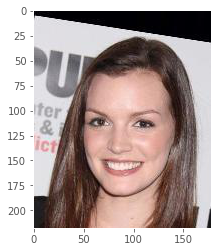

In [6]:
# plot picture and attributes
img = load_img(EXAMPLE_PIC)
plt.grid(False)
plt.imshow(img)
df_attr.loc[EXAMPLE_PIC.split('/')[-1]][['Smiling','Male','Young','Attractive']] #some attributes

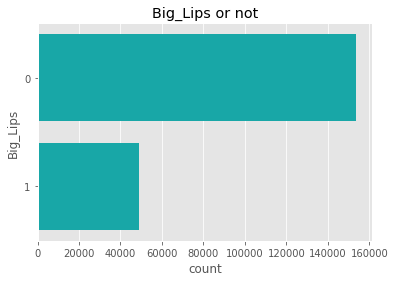

In [7]:
plt.title('Big_Lips or not')
sns.countplot(y='Big_Lips', data=df_attr, color="c")
plt.show()

## Split Dataset into training, test and validation ##

In [70]:
# Recomended partition
df_partition = pd.read_csv(main_folder + 'list_eval_partition.csv')
df_partition.head()

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


NameError: name 'image_id' is not defined

In [9]:
# display counter by partition
# 0 -> TRAINING
# 1 -> VALIDATION
# 2 -> TEST
df_partition['partition'].value_counts().sort_index()

0    162770
1     19867
2     19962
Name: partition, dtype: int64

In [13]:
# join the partition with the attributes
#df_partition.set_index('image_id', inplace=True)
df_par_attr = df_partition.join(df_attr['Male'], how='inner')
df_par_attr.head()

,partition,Male
image_id,,
000001.jpg,0,0
000002.jpg,0,0
000003.jpg,0,1
000004.jpg,0,0
000005.jpg,0,0


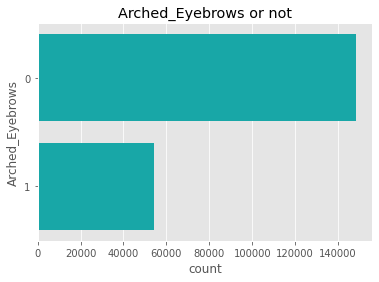

In [46]:
plt.title('Arched_Eyebrows or not')
sns.countplot(y='Arched_Eyebrows', data=df_attr, color="c")
plt.show()

In [50]:
df_par_attr = df_par_attr.join(df_attr['Oval_Face'], how='inner')
df_par_attr.head()

,partition,Male,Attractive,Arched_Eyebrows,Bags_Under_Eyes,Bald,Oval_Face
image_id,,,,,,,
000001.jpg,0,0,1,1,0,0,0
000002.jpg,0,0,0,0,1,0,0
000003.jpg,0,1,0,0,0,0,0
000004.jpg,0,0,1,0,0,0,0
000005.jpg,0,0,1,1,0,0,0


In [131]:
df_par_attr.iloc[1].to_numpy()

array([0, 0, 0, 0, 1, 0, 0])

In [86]:
n = 3
i = np.where(df_par_attr.index == df_par_attr.index[n])[0][0]
j = df_par_attr.index[n]

print(i, j)

3 000004.jpg


In [93]:
j = 0
for i in df_par_attr.index[:20]:
    print(i)
        

000001.jpg
000002.jpg
000003.jpg
000004.jpg
000005.jpg
000006.jpg
000007.jpg
000008.jpg
000009.jpg
000010.jpg
000011.jpg
000012.jpg
000013.jpg
000014.jpg
000015.jpg
000016.jpg
000017.jpg
000018.jpg
000019.jpg
000020.jpg


In [98]:
y = np.array([df_par_attr.iloc[np.where(df_par_attr.index == i)[0][0]].to_numpy() for i in df_par_attr.index[:30]])

In [135]:
def load_reshape_img(fname):
    img = load_img(fname)
    x = img_to_array(img)/255.
    x = x.reshape((1,) + x.shape)

    return x


def generate_df(partition, attr, num_samples):
    '''
    partition
        0 -> train
        1 -> validation
        2 -> test
    
    '''
    
    for attribute in attr:
        
        df_ = df_par_attr[(df_par_attr['partition'] == partition) 
                               & (df_par_attr[attr] == 0)].sample(int(num_samples/2))
        df_ = pd.concat([df_,
                          df_par_attr[(df_par_attr['partition'] == partition) 
                                      & (df_par_attr[attr] == 1)].sample(int(num_samples/2))])

    # for Train and Validation
    if partition != 2:
        x_ = np.array([load_reshape_img(images_folder + fname) for fname in df_.index])
        x_ = x_.reshape(x_.shape[0], 218, 178, 3)
        y_ = np.array([df_par_attr.iloc[np.where(df_par_attr.index == i)[0][0]].to_numpy() for i in df_par_attr.index])
    # for Test
    else:
        x_ = []
        y_ = []

        for index, target in df_.iterrows():
            im = cv2.imread(images_folder + index)
            im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0
            im = np.expand_dims(im, axis =0)
            x_.append(im)
            values = df_.iloc[np.where(df_.index == index)[0][0]].to_numpy()
            y_.append(values)

    return x_, y_

In [133]:
j = 0
y = []

for index, target in df_par_attr.iterrows():
    j += 1
    if j <= 20:
        a = df_par_attr.iloc[np.where(df_par_attr.index == index)[0][0]].to_numpy()
        y.append(a)
    else:
        break
y

[array([0, 0, 1, 1, 0, 0, 0]),
 array([0, 0, 0, 0, 1, 0, 0]),
 array([0, 1, 0, 0, 0, 0, 0]),
 array([0, 0, 1, 0, 0, 0, 0]),
 array([0, 0, 1, 1, 0, 0, 0]),
 array([0, 0, 1, 1, 0, 0, 0]),
 array([0, 1, 1, 0, 1, 0, 0]),
 array([0, 1, 0, 1, 1, 0, 0]),
 array([0, 0, 1, 1, 0, 0, 1]),
 array([0, 0, 1, 0, 0, 0, 0]),
 array([0, 0, 1, 0, 0, 0, 0]),
 array([0, 1, 1, 0, 1, 0, 1]),
 array([0, 1, 0, 0, 0, 0, 1]),
 array([0, 0, 0, 1, 0, 0, 0]),
 array([0, 1, 0, 0, 1, 0, 0]),
 array([0, 1, 0, 0, 1, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 1]),
 array([0, 0, 0, 1, 0, 0, 0]),
 array([0, 0, 1, 1, 0, 0, 1]),
 array([0, 1, 0, 0, 0, 0, 0])]

In [134]:
j = 0
y = []

for index, target in df_par_attr.iterrows():
    j += 1
    if j <= 20:
        y.append(target['Male'])
    else:
        break
y

[0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1]

## Data Augmentation example ##

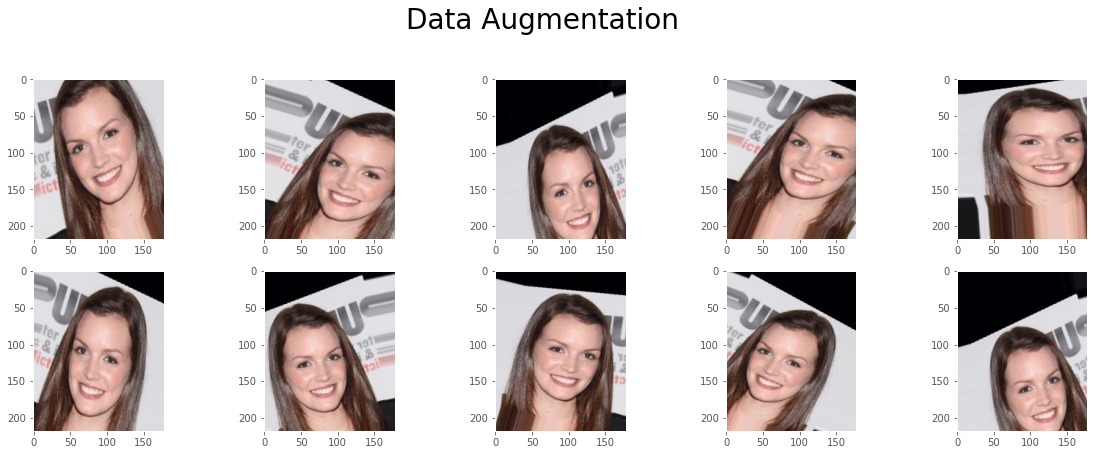

In [58]:
# Generate image generator for data augmentation
datagen =  ImageDataGenerator(
  #preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True
)

# load one image and reshape
img = load_img(EXAMPLE_PIC)
x = img_to_array(img)/255.
x = x.reshape((1,) + x.shape)

# plot 10 augmented images of the loaded iamge
plt.figure(figsize=(20,10))
plt.suptitle('Data Augmentation', fontsize=28)

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.subplot(3, 5, i+1)
    plt.grid(False)
    plt.imshow( batch.reshape(218, 178, 3))
    
    if i == 9:
        break
    i += 1
    
plt.show()

In [ ]:
# Train data
x_train, y_train = generate_df(0, 'Male', TRAINING_SAMPLES)

# Train - Data Preparation - Data Augmentation with generators
train_datagen =  ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
)

train_datagen.fit(x_train)

train_generator = train_datagen.flow(
x_train, y_train,
batch_size=BATCH_SIZE,
)

In [101]:
y_train.shape

(10000, 2)

In [24]:
# Validation Data
x_valid, y_valid = generate_df(1, 'Male', VALIDATION_SAMPLES)

'''
# Validation - Data Preparation - Data Augmentation with generators
valid_datagen = ImageDataGenerator(
  preprocessing_function=preprocess_input,
)

valid_datagen.fit(x_valid)

validation_generator = valid_datagen.flow(
x_valid, y_valid,
)
'''

'\n# Validation - Data Preparation - Data Augmentation with generators\nvalid_datagen = ImageDataGenerator(\n  preprocessing_function=preprocess_input,\n)\n\nvalid_datagen.fit(x_valid)\n\nvalidation_generator = valid_datagen.flow(\nx_valid, y_valid,\n)\n'

In [29]:
y_valid

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [28]:
x_valid.shape

(2000, 218, 178, 3)